One of the most basic machine learning algorithms is going to be quite familiar to everyone, and it's known as linear regression.  Regression (as opposed to classification) is the process of predicting a *real* valued output based on some input parameters.  Let's look at a problem that we might apply linear regression to.  Imagine that you work for UNICEF or some other multinational non-profit, and you want to know the infant mortality rate for the nation of Hungary.  However, let's imagine that that information has never been collected.  What we want to do then is to identify some proxy that might be related, for example per capita income, and make a prediction based on that.  Of course, we'll need to do some machine learning based on some other countries where we do know both PCI and infant mortality in order to make better predictions.

Such a dataset does exist, and I downloaded it from http://www.stat.ufl.edu/~winner/datasets.html, which has a ton of great datasets.  We can load them using pandas, which we import here:

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = [12,8]

The data is in a text format with spaces as delimiters.  Pandas has a nice parsing utility that we can use to read the file

In [3]:
data = pd.read_csv('datasets/birthrate.dat',header=0,sep=r"\s{2,}",engine='python',index_col=0)
test_set = data.loc['Hungary']
data = data.drop('Hungary')

Notice that this dataset does actually include Hungary, but I've split it from the training set for instructional purposes.    

Let's have a look at what we just imported.  The Jupyter notebook has support for pandas data objects, which means they'll print nicely if we just say...

In [4]:
data

,Birth Rate,PCI,Farm Pop,Infant Mortality
Country,,,,
Venezuela,46.4,392,0.40,68.5
Mexico,45.7,118,0.61,87.8
Ecuador,45.3,44,0.53,115.8
Colombia,38.6,158,0.53,106.8
Ceylon,37.2,81,0.53,71.6
Puerto Rico,35.0,374,0.37,60.2
Chile,34.0,187,0.30,118.7
Canada,28.3,993,0.19,33.7
United States,24.7,1723,0.12,27.2


Now that we have the data table, let's use matplotlib to plot per capita income against infant morality

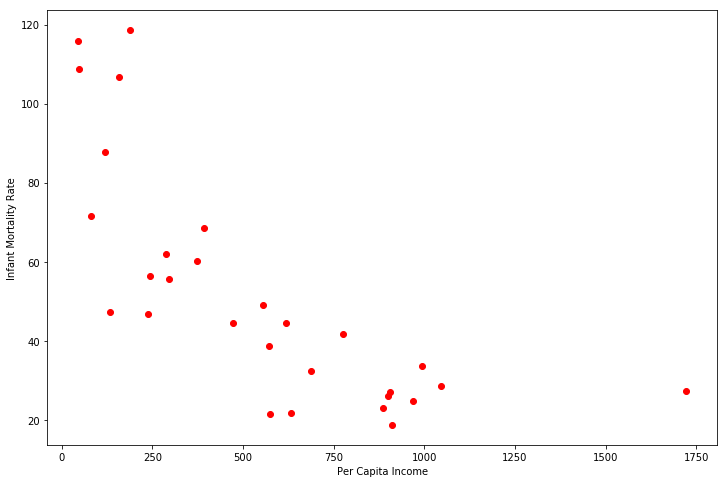

In [5]:
plt.plot(data['PCI'],data['Infant Mortality'],'ro')
plt.xlabel('Per Capita Income')
plt.ylabel('Infant Mortality Rate')
plt.show()

That weird point out to the right is kind of screwing things up, so let's drop it manually.

In [6]:
data = data.drop('United States')

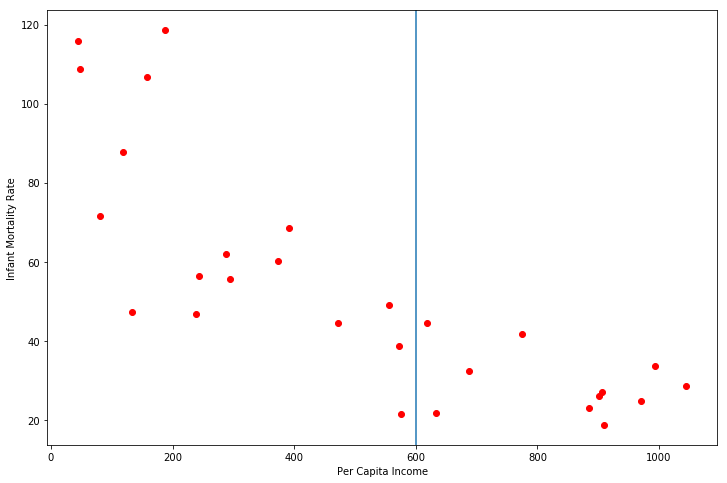

In [7]:
plt.plot(data['PCI'],data['Infant Mortality'],'ro')
plt.axvline([600])
plt.xlabel('Per Capita Income')
plt.ylabel('Infant Mortality Rate')
plt.show()


There's a clear, but noisy trend here.  Let's see if we can model these data.  Note once again that what we're doing now is slightly different from classification: rather than using features to predict a discrete value (the class), we're trying to predict a real value (infant mortality rate).  

However, mostly the mechanics are the same.  So how to proceed?  First, we need to come up with a model for the data.  A common assumption for data in general when you don't have any better ideas is to assume that for a given attribute the data are normally distributed.  This is to say that if we picked PCI of 600, simulated countries with that PCI, and then recorded their mortality rate, that the mortality rate would follow a bell curve.  This is to say, that if we had access to infinite numbers of countries with PCI of 600, the histogram of infant mortality rates would look like this:


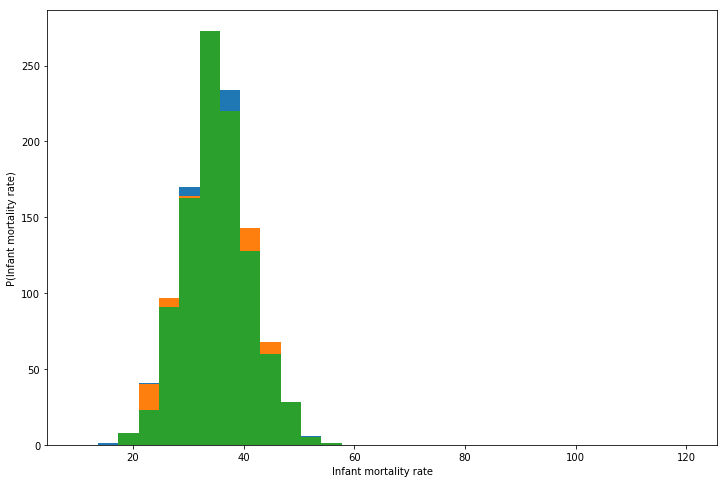

In [10]:
mu_600 = 35.
sigma = 6

plt.hist(np.random.randn(1000)*sigma + mu_600,np.linspace(10,120,31))
plt.xlabel('Infant mortality rate')
plt.ylabel('P(Infant mortality rate)')
plt.show()

However, we don't have enough data to learn the parameters for every possible value of PCI (of which there are infinite because it's real valued), so instead, we're going to parameterize the parameter, and say that the mean of the normal distribution follows some function.  Let's call the mean $\mu(x)$, where $x$ is shorthand for the PCI.  <font color=red>What's a reasonable function for $\mu(x)$?</font>  

Now that we have *parameterized our parameter*, we can write down the likelihood function for the data.
$$
\underbrace{P(\mathbf{y}|\mathbf{x})}_{\mathrm{likelihood}} = \prod_{i=1}^m N(y_i|\mu(x_i),\Sigma).
$$
Let's assume that the covariance matrix is actually just a scalar $\sigma^2$, which is to say that all the points have the same amount of uncertainty, and they're all independent of one another.  
$$
\underbrace{P(\mathbf{y}|\mathbf{x})}_{\mathrm{likelihood}} = \prod_{i=1}^m N(y_i|\mu(x_i),\sigma^2) \propto \exp \left[ -\frac{1}{2\sigma^2} (\mathbf{y} - \mu(\mathbf{x})^T (\mathbf{y} - \mu(\mathbf{x})) \right].
$$
Now, if we want to fit this model to the data (i.e. find the values of the parameters of $\mu(x)$), we can do what we've done in previous cases and find the maximum likelihood solution.  As before, it's easiest to take the logarithm first to make things easier:
$$
\ln P(\mathbf{y}|\mathbf{x},w_0,w_1,\sigma^2) \propto \sum_{i=1}^m \frac{1}{2 \sigma^2} (y_i - \mu(x))^2.
$$
A simple model is that $\mu(x) = w_0 + w_1 x$.  Of course we can find the minimum to this by taking derivatives and setting equal to zero, but let's first just search all possible parameter values.

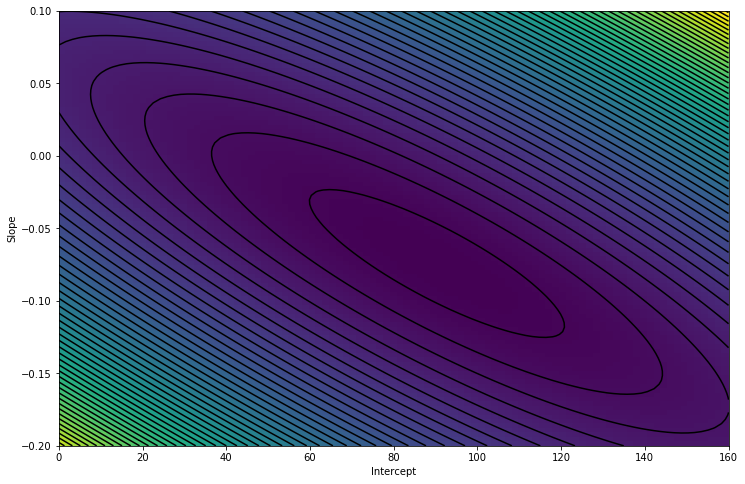

In [13]:
x = data['PCI'].as_matrix().astype(float)
y = data['Infant Mortality'].as_matrix().astype(float)

w0_sweep = np.linspace(0,160,100)
w1_sweep = np.linspace(0.1,-0.2,100)

W0_grid,W1_grid = np.meshgrid(w0_sweep,w1_sweep)
cost_list = np.zeros_like(W0_grid)

for i,w1 in enumerate(w1_sweep):
    for j,w0 in enumerate(w0_sweep):
        cost = 0.5*np.dot(y - (w1*x + w0),y - (w1*x + w0))
        cost_list[i,j] = cost

plt.pcolor(W0_grid,W1_grid,cost_list)
plt.contour(W0_grid,W1_grid,cost_list,50,colors='k')
plt.xlabel('Intercept')
plt.ylabel('Slope')
plt.show()



So we can look and see that the slope is slightly negative (around -0.08), and the intercept is something like 95.  Of course this isn't really a viable approach for larger scale problems, so we need to figure out the max-like solution.  

### The normal equations
We can compute the derivatives directly for this problem:
$$ \frac{\partial I}{\partial w_0} = - \sum_{i=1}^m (y_i - w_1 x_i - w_0) 1$$
$$ \frac{\partial I}{\partial w_1} = - \sum_{i=1}^m (y_i - w_1 x_i - w_0)x_i $$
Setting these equal to zeros provides the two equations
$$ \sum_{i=1}^m (y_i 1) = \sum_{i=1}^m w_1 x_i + \sum_{i=1}^m w_0 1 $$.
$$ \sum_{i=1}^m (y_i x_i) = \sum_{i=1}^m w_1 x_i^2 + \sum_{i=1}^m w_0 x_i $$
This can be written more succinctly in matrix form as
$$ X^T X W = X^T \mathbf{y}, $$
where $W = [w_0,w_1]^T$ and 
$$ X = \left[ \begin{array}{cc} 1 & x_0 \\ 1 & x_1 \\ \vdots & \vdots \\ 1 & x_m \end{array} \right]. $$ 
$X^T X$ is a 2 by 2 matrix, and $X^T y$ is 2 by 1 vector, and we can easily solve this equation for $W$ using any technique for solving systems of linear equations.  This equation is called the *Normal Equations*, so called not because they're so common, but because they define an orthogonal projection of the data onto the columns of $X$.  **Note that with these variables defined, we can write $\mu = XW$: the predicted mean is given by the design matrix times the weights.**

In [12]:
X = np.column_stack([np.ones_like(x),x])
W = np.linalg.solve(np.dot(X.T,X),np.dot(X.T,y))

Let's see how this value of $w_0$ and $w_1$ compares to our error surface that we computed above 

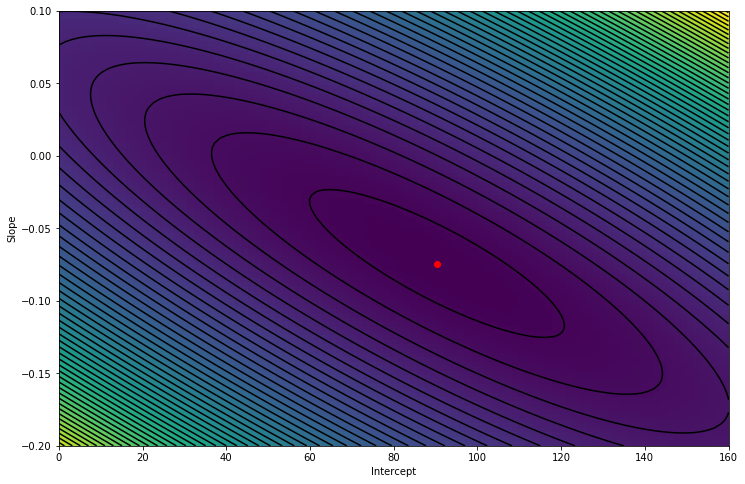

In [14]:
plt.pcolor(W0_grid,W1_grid,cost_list)
plt.contour(W0_grid,W1_grid,cost_list,50,colors='k')
plt.plot(W[0],W[1],'ro')
plt.xlabel('Intercept')
plt.ylabel('Slope')
plt.show()

Pretty Good!  And the fit to the data?

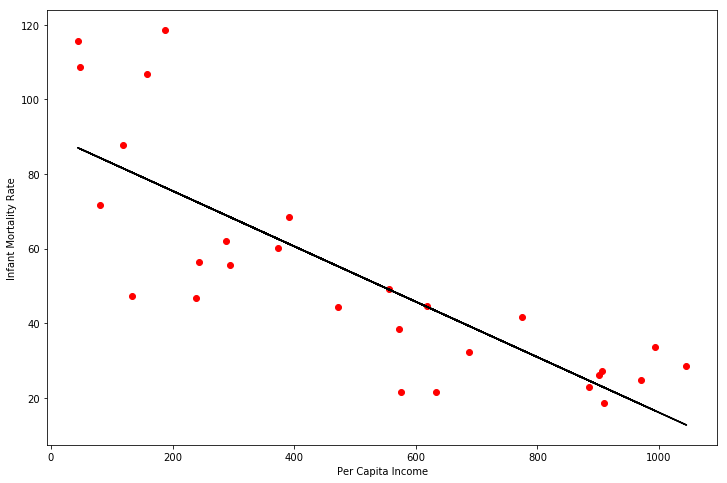

In [15]:
y_pred = np.dot(X,W)

plt.plot(x,y,'ro')
plt.plot(x,y_pred,'k-')
plt.xlabel('Per Capita Income')
plt.ylabel('Infant Mortality Rate')
plt.show()


And our prediction for Hungary?

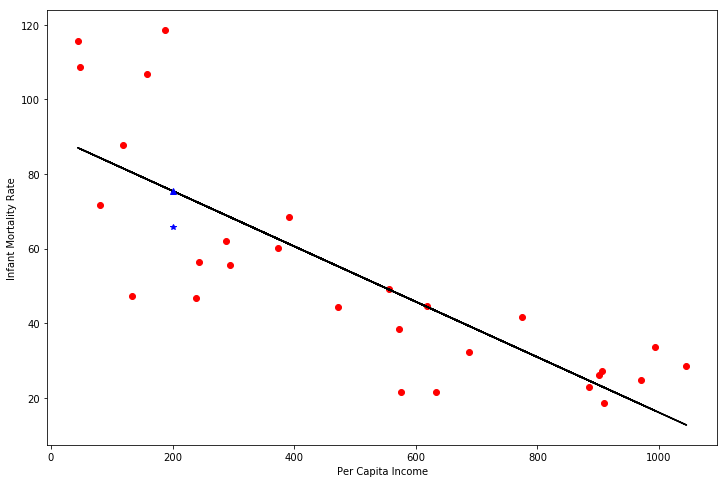

Avg. RMSE:  17.3866938747
Hungary Error:  9.78197016244


In [16]:
y_test = W[0] + W[1]*test_set['PCI']

plt.plot(x,y,'ro')
plt.plot(x,y_pred,'k-')
plt.plot(test_set['PCI'],test_set['Infant Mortality'],'b*')
plt.plot(test_set['PCI'],y_test,'b^')
plt.xlabel('Per Capita Income')
plt.ylabel('Infant Mortality Rate')
plt.show()

avg_rmse = np.sqrt(np.sum((np.dot(X,W) - y)**2)/len(y))
test_error = abs(y_test - test_set['Infant Mortality'])

print ("Avg. RMSE: ",avg_rmse)
print ("Hungary Error: ",test_error)

Not too bad!  Our prediction is much better than if we had just randomly guessed.  We can say that we have learned something.  

### Basis Functions
But can we do better with this data?  We've imposed some really strong assumptions by using a straight line as a model.  So, for this data, what happens if we select a model that has somewhat more explanatory power?

The 'linear' in linear regression doesn't actually refer to the fact that we modelled the data with a straight line.  In fact, it refers to the fact that we were able to find the minimizing parameter values through the solution of a linear set of equations (the normal equations given above).  Indeed, so long as our model is a linear combination of arbitrary functions of $x$, like
$$ \mu(x) = w_0 + w_1 \exp (-(x-100)^2) + w_2 x^7. $$
Because this expression is linear in $W$, we can again write this as 
$$
\mu(x) = XW,
$$ where 
$$
X = 
\left[ \begin{array}{ccc} 1 & \exp-(x_0 - 100)^2 & x_0^7 \\
                          1 & \exp-(x_1 - 100)^2 & x_1^7 \\
                          \vdots & \vdots & \vdots \\
                          1 & \exp-(x_m - 100)^2 & x_m^7 \end{array} \right].
$$
To find the best fit values for $W$, we still use the normal equations
$$ X^T X W = X^T \mathbf{y}.
$$

The individual functions of $x$  which are summed up are called 'basis functions', and are often denoted as $\phi_i(x)$.  For the above example, then there are three basis functions
$$ \phi_0(x)=1, \phi_1(x) = \exp(-(x-100)^2), \phi_2(x) = x^7. $$
As long as these basis functions are not functions of the weights themselves, then we can write the model for the mean as 
$\mu(x) = XW$.  **It's important to emphasize the following point: for regression to remain linear, the model parameters cannot appear in $\phi$!**  This means that fitting the function 
$$ w_0 + w_1 \exp(-x/w_2) + w_3 x^7 $$
would not work, at least not in the sense of having the easy closed form solution presented here.  Note that these are probably not very well selected basis functions: for real problems we will want to select them carefully (or better yet, *learn* them, which is what a neural network does).

### Polynomial Regression
A particularly common model takes the form 
$$ \mu(x) = w_0 + w_1 x + w_2 x^2 + \ldots + w_m x^m, $$
a polynomial of degree $m$.  The basis functions are the set of monomials:
$$ \phi_i(x) = x^i, \forall i\in[1,\ldots,m]. $$  This produces a matrix $X$ (also known as a design matrix), that looks like this:  
$$ X = 
\left[ \begin{array}{cccc} \phi_0(x_0) & \phi_1(x_0) & \cdots & \phi_m(x_0) \\ \phi_0(x_1) & \phi_1(x_1) & \cdots & \phi_m(x_1) \\ \vdots & \vdots & \ddots & \vdots \\ \phi_0(x_n) & \phi_1(x_n) & \cdots & \phi_m(x_n) \end{array} \right] =
\left[ \begin{array}{cccc} 1 & x_0 & \cdots & x_0 ^m \\ 1 & x_1 & \cdots & x_1^m \\ \vdots & \vdots & \ddots & \vdots \\ 1 & x_n & \cdots & x_n^m \end{array} \right]. $$

This matrix is also known as a Vandernonde matrix, and is common enough that numpy has a built-in function to produce it.  Let's see what happens for a quadratic polynomial (aka $m=2$): 


In [17]:
xmin = x.min()
xmax = x.max()

x_test = (test_set['PCI'] - xmin)/(xmax - xmin)
x = (x - xmin)/(xmax-xmin)

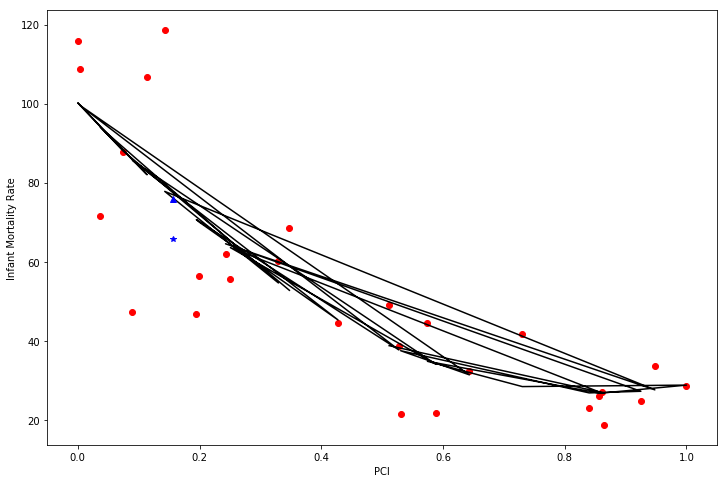

In [18]:
import numpy as np
# Generate a Vandermonde matrix
degree = 2

X = np.vander(x,degree+1,increasing=True)
W = np.linalg.solve(np.dot(X.T,X),np.dot(X.T,y))

y_pred = np.dot(X,W)

X_test= np.vander([x_test],degree+1,increasing=True)
y_test = np.dot(X_test,W)

plt.plot(x,y,'ro')
plt.plot(x,y_pred,'k-')
plt.plot(x_test,test_set['Infant Mortality'],'b*')
plt.plot(x_test,y_test,'b^')
plt.xlabel('PCI')
plt.ylabel('Infant Mortality Rate')
plt.show()

Note that this looks pretty crappy in plots because the points are out of order and not smoothly varying.  Let's introduce a new variable *xhat* that is more densely spaced and is ordered so that we can correctly plot the curves that we produce.

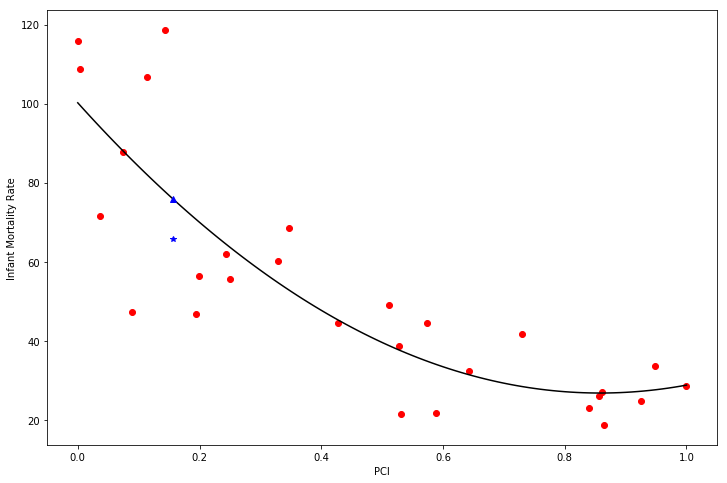

Avg. RMSE:  15.3412262537
Hungary Error:  10.2649878738


In [19]:
xhat = np.linspace(x.min(),x.max(),101)
Xhat = np.vander(xhat,degree+1,increasing=True)

y_pred = np.dot(Xhat,W)

plt.plot(x,y,'ro')
plt.plot(xhat,y_pred,'k-')
plt.plot(x_test,test_set['Infant Mortality'],'b*')
plt.plot(x_test,y_test,'b^')
plt.xlabel('PCI')
plt.ylabel('Infant Mortality Rate')
plt.show()

avg_rmse = np.sqrt(np.sum((np.dot(X,W) - y)**2)/len(y))
test_error = abs(y_test[0] - test_set['Infant Mortality'])

print ("Avg. RMSE: ",avg_rmse)
print ("Hungary Error: ",test_error)

Much better.  

Note that this didn't help our predictive accuracy much for Hungary (in fact the error has gone up), but we can see that in general, we've reduced the misfit for all the other points.  Let's keep going by increasing the polynomial degree to 5.


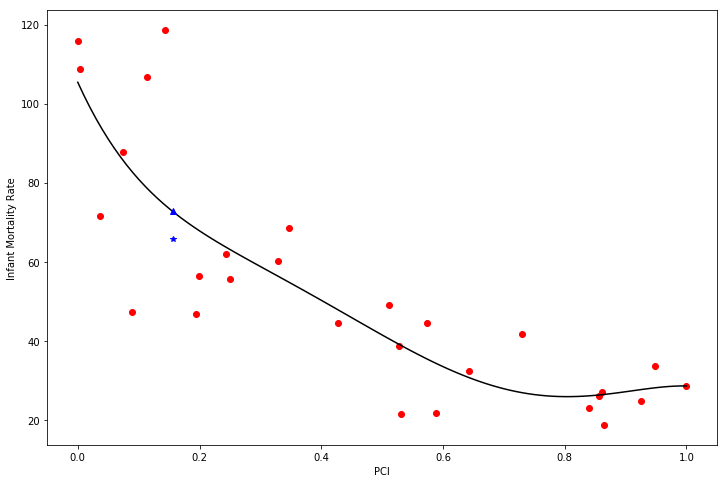

Avg. RMSE:  15.1993280766
Hungary Error:  7.04203211233


In [20]:
degree = 5

X = np.vander(x,degree+1,increasing=True)
W = np.linalg.solve(np.dot(X.T,X),np.dot(X.T,y))

Xhat = np.vander(xhat,degree+1,increasing=True)
yhat = np.dot(Xhat,W)

X_test = np.vander([x_test],degree+1,increasing=True)
y_test = np.dot(X_test,W)

plt.plot(x,y,'ro')
plt.plot(xhat,yhat,'k-')
plt.plot(x_test,test_set['Infant Mortality'],'b*')
plt.plot(x_test,y_test,'b^')
plt.xlabel('PCI')
plt.ylabel('Infant Mortality Rate')
plt.show()

avg_rmse = np.sqrt(np.sum((np.dot(X,W) - y)**2)/len(y))
test_error = abs(y_test[0] - test_set['Infant Mortality'])

print ("Avg. RMSE: ",avg_rmse)
print ("Hungary Error: ",test_error)

Same story, slightly better RMSE, prediction error for Hungary has gone down this time.  What if we really ramp up the model complexity

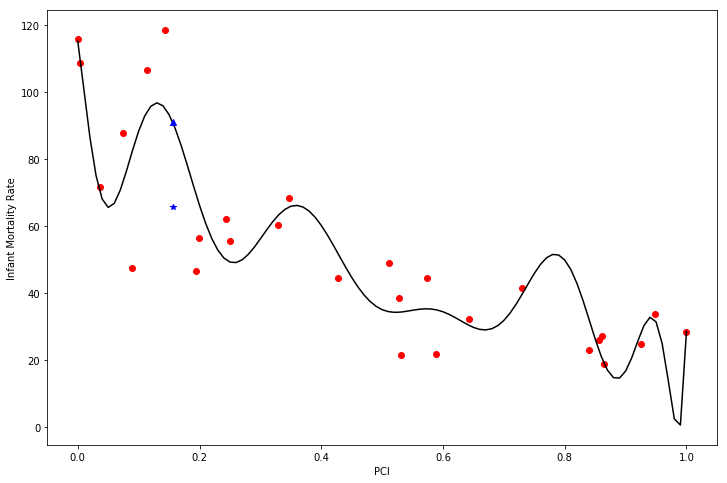

Avg. RMSE:  11.7163715908
Hungary Error:  25.36809894


In [21]:
degree = 17

X = np.vander(x,degree+1,increasing=True)
W = np.linalg.solve(np.dot(X.T,X),np.dot(X.T,y))

Xhat = np.vander(xhat,degree+1,increasing=True)
yhat = np.dot(Xhat,W)

X_test = np.vander([x_test],degree+1,increasing=True)
y_test = np.dot(X_test,W)

avg_rmse = np.sqrt(np.sum((np.dot(X,W) - y)**2)/len(y))

plt.plot(x,y,'ro')
plt.plot(xhat,yhat,'k-')
plt.plot(x_test,test_set['Infant Mortality'],'b*')
plt.plot(x_test,y_test,'b^')
plt.xlabel('PCI')
plt.ylabel('Infant Mortality Rate')
plt.show()

avg_rmse = np.sqrt(np.sum((np.dot(X,W) - y)**2)/len(y))
test_error = abs(y_test[0] - test_set['Infant Mortality'])

print ("Avg. RMSE: ",avg_rmse)
print ("Hungary Error: ",test_error)

This time, our average error in the training set has gone down alot, but our prediction for Hungary is getting worse!  <font color=red> What's causing this behavior? </font>

### Overfitting
The reason for this is straightforward: we're starting to fit the noise, rather than the signal.  There's a certain amount of error associated with a given label or measurement.  Some of this is from measurement error itself (Not every instance of infant mortality was counted, for example), and some of it is due to factors that we do not have any information about (perhaps a war drove up rates for a particular nation over the measurement period).  If we fit these factors, we're not going to get a good prediction because they're essentially random (from our point of view) for each county.  **Our goal henceforth is not only to determine how to train models effectively, but also to select models in such a way that they give good predictive values for test data, rather than overfitting training data.**

One way of ensuring that we don't overfit is to carefully select our basis functions to be consistent with our a priori assumptions about the data.  This is useful in the case when we have some known physics that we're trying to find the parameters to.  For example, if we measure a series of positions for a cannonball under the influence of gravity in a vacuum in an attempt to infer the initial velocity and position, then we know that a parabola is the right shape to fit.  

However, often don't know the functional relationship to start: this is the big difference between machine learning and other inverse methods.  This problem is easily solved by a complete application of Bayes' rule.  Recall that in finding our answer for the parameter values, we performed *Maximum likelihood estimation*, which is to say that we found the parameters that minimized the misfit with the data:
$$
\hat{W} = \mathrm{argmax}_W P(\mathbf{y}|\mathbf{x},W).
$$
Note that this doesn't include any prior information about $W$.  Thus $W$ can take any values that it wants to.  For the 17th order polynomial we fit above, what were the parameter values?


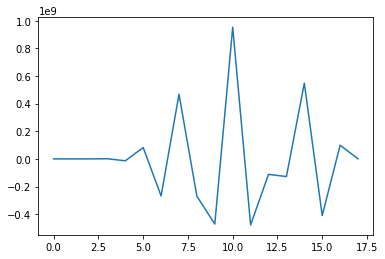

In [69]:
plt.plot(W)

In an effort to fit the data as well as possible, we've instead gotten wild oscillations in parameter values.  This is clearly not desirable behavior if we want to make sense of this model, or its predictions.  How can we get fix this problem?

The answer comes from Bayes rule: instead of finding the maximum likelihood solution, let's find the maximum of the complete posterior.  Bayes' rule tells us that 
$$
P(W|\mathbf{y},\mathbf{x}) \propto P(y|W,\mathbf{x}) P(W|\mathbf{x}).
$$
Thus, we need to select a prior on $W$.  We've already stated that we don't want our parameters to be too big.  As such, we can assume that our parameter values follow a normal distribution with mean and a standard deviation of $\sigma_w$.  Thus:
$$
P(W|\mathbf{x}) = P(W) = \mathcal{N}(W|0,\sigma_w^2),
$$

Multiplying the prior and the likelihood together, we get
$$
P(W|\mathbf{y}) \propto \exp -\frac{1}{2} \frac{(\mathbf{y} - X W)^T (\mathbf{y} - X W)}{\sigma^2} + \frac{W^T W}{\sigma_w^2}).
$$
If we do some tricky linear algebra (in particular, a process called *completing the square*), we find that the posterior distribution of the parameters actually has a closed form solution. 
$$
P(W|\mathbf{y},\mathbf{x}) = \mathcal{N}(W|\mu_{post},\sigma_{post}),
$$
with parameters given by 
$$
\mu_{post} = [X^T X + \frac{\sigma}{\sigma_w}^2 ]^{-1} X^T \mathbf{y}
$$
$$
\Sigma_{post} = [\frac{X^T X}{\sigma^2} + \frac{1}\sigma_w^2]^{-1}.
$$
Why is this interesting?  As it turns out, you can also get these parameter values by minimizing the function
$$ \sum_{i=1}^m \frac{1}{2} [y_i - \mu(x_i)]^2 + \sum_{j=1}^n \gamma w_j^2 $$,
where $\gamma = \frac{\sigma_w}{\sigma}^2$.  Note that this $\gamma$ term is basically the ratio between how certain we are that the parameter values should be small and how certain we are in the data.  If we believe the data very accurately, then we have to try very hard to make the parameters small.  If we don't feel like the data are reliable, then the model will default to trying to make the parameters small.  This penalty on large parameter values is called Tikhonov regularization.

Minimizing this function is almost exactly the same as least squares function we outline above, but with an additional term.  The solution to this *regularized* least squares problem is
$$ (X^T X + \gamma \mathcal{I}) W = X^T y, $$
where $\mathcal{I}$ is the identity matrix.

Let's see how this influences the fit.  Using the same 

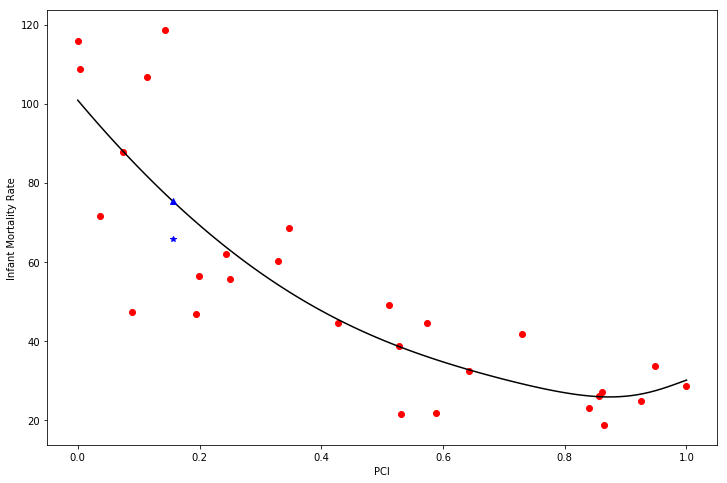

Avg. RMSE:  15.3042804578
Hungary Error:  9.66853707274


In [22]:
degree = 17

gamma = 1e-3
Eye = np.eye(X.shape[1])
Eye[0,0] = 0

W = np.linalg.solve(np.dot(X.T,X) + gamma*Eye,np.dot(X.T,y))

yhat = np.dot(Xhat,W)
y_test = np.dot(X_test,W)

plt.plot(x,y,'ro')
plt.plot(xhat,yhat,'k-')
plt.plot(x_test,test_set['Infant Mortality'],'b*')
plt.plot(x_test,y_test,'b^')
plt.xlabel('PCI')
plt.ylabel('Infant Mortality Rate')
plt.show()

avg_rmse = np.sqrt(np.sum((np.dot(X,W) - y)**2)/len(y))
test_error = abs(y_test[0] - test_set['Infant Mortality'])

print ("Avg. RMSE: ",avg_rmse)
print ("Hungary Error: ",test_error)

Let's look at our parameter values now:

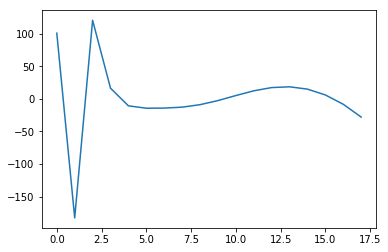

In [74]:
plt.plot(W)
plt.show()

We've effectively limited the complexity of our model.  This can be very useful when we want to fit a model which is very complicated, but for which we want our parameter values to be smooth.

What happens though if we over-regularize?

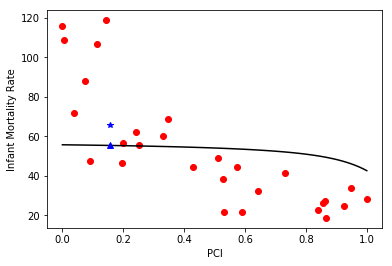

Avg. RMSE:  27.63543521266052
Hungary Error:  10.338159780759646


In [75]:
degree = 17

gamma = 1e2
Eye = np.eye(X.shape[1])
Eye[0,0] = 0

W = np.linalg.solve(np.dot(X.T,X) + gamma*Eye,np.dot(X.T,y))

yhat = np.dot(Xhat,W)
y_test = np.dot(X_test,W)

plt.plot(x,y,'ro')
plt.plot(xhat,yhat,'k-')
plt.plot(x_test,test_set['Infant Mortality'],'b*')
plt.plot(x_test,y_test,'b^')
plt.xlabel('PCI')
plt.ylabel('Infant Mortality Rate')
plt.show()

avg_rmse = np.sqrt(np.sum((np.dot(X,W) - y)**2)/len(y))
test_error = abs(y_test[0] - test_set['Infant Mortality'])

print ("Avg. RMSE: ",avg_rmse)
print ("Hungary Error: ",test_error)

This is too much regularization.  We've effectively made our degree 17 polynomial into a function that just fits the mean.  How do we know how much regularization is correct?  This is the nature of problem 2 on HW4.


### More exotic basis functions
As I mentioned above, the linear in linear regression comes from the ability to write models as linear combinations of known functions.  Just for fun, let's do this exercise for some periodic data that we'll make up.  In particular, let's look at a particularly challenging example, the sawtooth wave.    

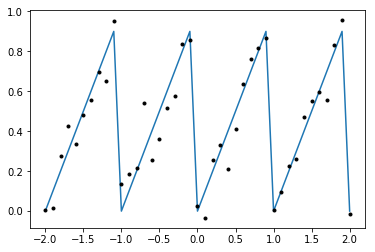

In [79]:
N_data = 41
x = np.linspace(-2,2,N_data)
xhat = np.linspace(-2,2,501)
y_true = x - np.floor(x)
y = y_true + np.random.randn(N_data)*0.1
plt.plot(x,y_true)
plt.plot(x,y,'k.')
plt.show()

The natural set of functions for capturing a periodic function is the Fourier series, which is just a sum of signs and cosines of increasing frequency.  Much like with polynomials, we need to select the complexity of our model.  As before, it's a tradeoff between overfitting and underfitting.  Let's start with the Fourier series up to their third terms.
$$
\mu(x) = w_0 + \sum_{N=1}^3 w_i \cos 2 \pi N x + \sum_{N=1}^3 w_{i+3} \sin 2 \pi N x
$$


In [83]:
degree = 3
X = np.column_stack([np.ones_like(x)]  
                  + [np.cos(N*2*np.pi*x) for N in range(1,degree+1)] 
                  + [np.sin(N*2*np.pi*x) for N in range(1,degree+1)])

Xhat = np.column_stack([np.ones_like(xhat)] + [np.cos(N*2*np.pi*xhat) for N in range(1,degree+1)] + [np.sin(N*2*np.pi*xhat) for N in range(1,degree+1)])

The nice thing about design matrices is that their columns are the basis functions themselves, so we can easily plot them, just to get a sense of what we're working with before doing any fitting.

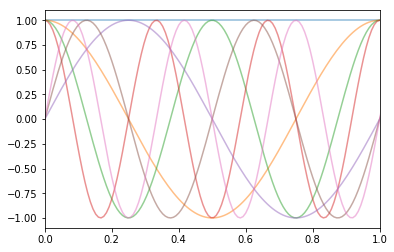

In [84]:
for i in range(0,2*degree+1):
    plt.plot(xhat,Xhat[:,i],alpha=0.5)
plt.xlim(0,1)
plt.show()

The normal equations do not change.  We still have to solve
$$ (X^T X + \gamma \mathcal{I} )W = X^T y $$ 
to get the optimal model parameters $W$.    

In [85]:
gamma = 0
Eye = np.eye(X.shape[1])
Eye[0,0] = 0
W = np.linalg.solve(np.dot(X.T,X) + gamma*Eye,np.dot(X.T,y))

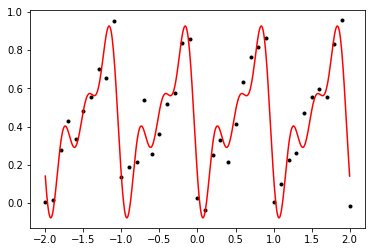

In [86]:
plt.plot(x,y,'k.')
plt.plot(xhat,np.dot(Xhat,W),'r-')
plt.show()

We're still subject to overfitting if we give the model too much freedom:

In [87]:
degree = 8
X = np.column_stack([np.ones_like(x)]  
                  + [np.cos(N*2*np.pi*x) for N in range(1,degree+1)] 
                  + [np.sin(N*2*np.pi*x) for N in range(1,degree+1)])

Xhat = np.column_stack([np.ones_like(xhat)] + [np.cos(N*2*np.pi*xhat) for N in range(1,degree+1)] + [np.sin(N*2*np.pi*xhat) for N in range(1,degree+1)])


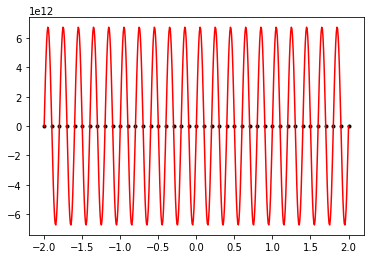

In [88]:
gamma = 0
Eye = np.eye(X.shape[1])
Eye[0,0] = 0
W = np.linalg.solve(np.dot(X.T,X) + gamma*Eye,np.dot(X.T,y))
plt.plot(x,y,'k.')
plt.plot(xhat,np.dot(Xhat,W),'r-')
plt.show()

Finally, we can still regularize in exactly the same way to ensure that the model is of limited complexity:

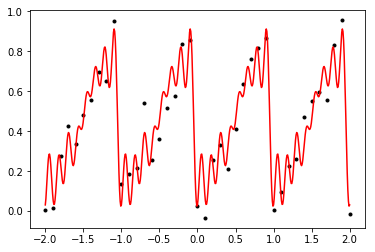

In [92]:
gamma = 1e-3
Eye = np.eye(X.shape[1])
Eye[0,0] = 0
W = np.linalg.solve(np.dot(X.T,X) + gamma*Eye,np.dot(X.T,y))
plt.plot(x,y,'k.')
plt.plot(xhat,np.dot(Xhat,W),'r-')
plt.show()